In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
import tqdm


In [98]:
train_env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")

/Users/friedrichwilkegrosche/miniforge3/envs/hivemind/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [99]:
SEED = 1234

train_env.reset(seed = SEED)
test_env.reset(seed = SEED + 1)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [100]:
class MLP(nn.Module):
    """
    Multilayer Perceptron (MLP) model.
    Has one hidden layer with ReLU activation.
    


    """

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x


In [101]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super(ActorCritic, self).__init__()
        self.actor = actor
        self.critic = critic

    def forward(self, state):
        action = self.actor(state)
        value = self.critic(state)
        return action, value

In [102]:
input_dim = train_env.observation_space.shape[0]
output_dim = train_env.action_space.n
hidden_dim = 32

In [103]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
def train(env, policy, optimizer, discount_factor, device):
    policy.train()
    log_prob_actions = []
    entropy_losses = []
    value_preds = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_pred, value_pred = policy(state)
        action_prob = F.softmax(action_pred, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy_loss = dist.entropy()
        state, reward, done, _ = env.step(action.item())
        log_prob_actions.append(log_prob)
        entropy_losses.append(entropy_loss)
        value_preds.append(value_pred)
        rewards.append(reward)
        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    entropy_losses = torch.cat(entropy_losses)
    value_preds = torch.cat(value_preds)
    returns = calculate_returns(value_preds, discount_factor, device)
    advantages = calculate_advantages(returns, value_preds)

    loss = update_policy(advantages, log_prob_actions,
                         returns, value_preds, entropy_losses, optimizer)

    return loss, episode_reward



In [106]:
def calculate_returns(rewards, discount_factor, device, normalize=True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns).to(device)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns


In [107]:


def calculate_advantages(returns, pred_values, normalize=True):

    advantages = returns - pred_values

    if normalize:

        advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages


In [108]:


def update_policy(advantages, log_prob_actions, returns, value_preds, entropies, optimizer):

    returns = returns.detach()

    policy_loss = -(advantages * log_prob_actions).mean()
    value_loss = F.smooth_l1_loss(returns, value_preds)

    optimizer.zero_grad()

    loss = policy_loss + value_loss * 0.5 - entropies.mean() * 0.01

    loss.backward()

    optimizer.step()

    return loss.item()


In [109]:


def evaluate(env, policy, device):

    policy.eval()

    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        with torch.no_grad():

            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim=-1)

        action = torch.argmax(action_prob, dim=-1)

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward

    return episode_reward


In [113]:
n_runs = 5
max_episodes = 300
discount_factor = 0.99

train_rewards = torch.zeros(n_runs, max_episodes)
test_rewards = torch.zeros(n_runs, max_episodes)
device = torch.device('cpu')

for run in range(n_runs):

    actor = MLP(input_dim, hidden_dim, output_dim)
    critic = MLP(input_dim, hidden_dim, 1)
    actor_critic = ActorCritic(actor, critic)
    actor_critic = actor_critic.to(device)
    actor_critic.apply(init_weights)
    optimizer = optim.Adam(actor_critic.parameters(), lr=1e-2)

    for episode in tqdm.tqdm(range(max_episodes), desc=f'Run: {run}'):

        loss, train_reward = train(
            train_env, actor_critic, optimizer, discount_factor, device)

        test_reward = evaluate(test_env, actor_critic, device)

        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward


Run: 0:   0%|          | 0/300 [00:00<?, ?it/s]/var/folders/v7/gtqrvtyj5h30wtj2kssyxky80000gn/T/ipykernel_16797/1031176032.py:6: UserWarning: Using a target size (torch.Size([21, 1])) that is different to the input size (torch.Size([21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(returns, value_preds)
/var/folders/v7/gtqrvtyj5h30wtj2kssyxky80000gn/T/ipykernel_16797/1031176032.py:6: UserWarning: Using a target size (torch.Size([39, 1])) that is different to the input size (torch.Size([39])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(returns, value_preds)
/var/folders/v7/gtqrvtyj5h30wtj2kssyxky80000gn/T/ipykernel_16797/1031176032.py:6: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([23])). This will likely lead to incorrect results due to broadcasti

Text(0, 0.5, 'Rewards')

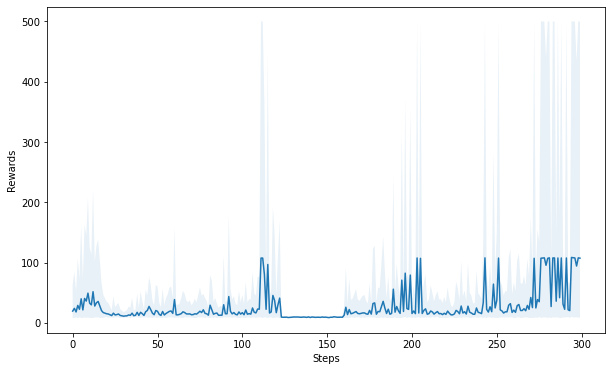

In [114]:


idxs = range(max_episodes)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(idxs, test_rewards.mean(0))
ax.fill_between(idxs, test_rewards.min(0).values,
                test_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Steps')
ax.set_ylabel('Rewards')


In [112]:
x = torch.randn(2, 10)
y = torch.randn(2, 10)
print(F.smooth_l1_loss(x, y))
print(F.mse_loss(x, y))


tensor(0.6787)
tensor(2.3543)
